# Cell Tracking and Lineage Construction in Live-Cell Imaging Data
---


### Global Imports

In [1]:
import os
import datetime
import errno
import argparse

import numpy as np

import deepcell

Using TensorFlow backend.


### Load the Training Data

In [2]:
# Download the data (saves to ~/.keras/datasets)
filename = '3T3_NIH.trks'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.tracked.nih_3t3.load_tracked_data(filename)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

X.shape: (188, 30, 154, 182, 1)
y.shape: (188, 30, 154, 182, 1)


### Set up filepath constants

In [3]:
# The path to the data file is currently required for `train_model_()` functions

# Change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

# DATA_FILE should be a trks file (contains 2 np arrays and a lineage dictionary)
DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [4]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

### Set up training parameters

In [5]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

tracking_model_name = 'tracking_model'

n_epoch = 5  # Number of training epochs
test_size = .10  # % of data saved as test

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# Tracking training settings
features = {"appearance", "distance", "neighborhood", "regionprop"}
min_track_length = 5
neighborhood_scale_size=30
batch_size = 128  

in_shape = (32, 32, 1) # Should this be calculated or hardcoded?
seed = 100 # To be removed

### Training the Model

#### Instantiate the tracking model

In [6]:
from deepcell import model_zoo

tracking_model = model_zoo.siamese_model(
    input_shape=in_shape,
    neighborhood_scale_size=neighborhood_scale_size,
    features=features)

#### Option 1: Train a new tracking model

In [7]:
from deepcell.training import train_model_siamese_daughter

tracking_model = train_model_siamese_daughter(
    model=tracking_model,
    dataset=DATA_FILE,  # full path to trks file
    model_name=tracking_model_name,
    optimizer=optimizer,
    batch_size=batch_size,
    min_track_length=min_track_length,
    features=features,
    neighborhood_scale_size=neighborhood_scale_size,
    n_epoch=n_epoch,
    model_dir=MODEL_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    class_weight=None)

training on dataset: /root/.keras/datasets/3T3_NIH.trks
saving model at: /data/models/tracking_model.h5
saving loss at: /data/models/tracking_model.npz
X_train shape: (212, 30, 154, 182, 1)
y_train shape: (212, 30, 154, 182, 1)
X_test shape: (24, 30, 154, 182, 1)
y_test shape: (24, 30, 154, 182, 1)
Output Shape: (None, 3)
Training on 1 GPUs
Using real-time data augmentation.


/usr/local/lib/python3.5/dist-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/usr/local/lib/python3.5/dist-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabl

total_train_pairs: 1485900.0
total_test_pairs: 142980.0
batch size: 128
validation_steps:  1117.0
Epoch 1/5


StopIteration: zero-size array to reduction operation maximum which has no identity

#### Option 2: Load an existing tracking model

In [4]:
# Import the tracking model
MODEL_DIR = '/data/models/'
PREFIX = 'cells/3T3/NIH/'

# Re-instantiate the model and load weights
siamese_weights_file = '2019-01-18_nuclear_movie_3T3_and_HeLa_complete_[a,d,n,r]_neighs=30_epochs=5_seed=101_trks_0.h5'
siamese_weights_file = os.path.join(MODEL_DIR, PREFIX, siamese_weights_file)

tracking_model.load_weights(siamese_weights_file)

#### Verify Model Accuracy with Confusion Matrix

In [ ]:
import deepcell.image_generators as generators

datagen_val = generators.SiameseDataGenerator(
        rotation_range=0,  # randomly rotate images by 0 to rotation_range degrees
        shear_range=0,     # randomly shear images in the range (radians , -shear_range to shear_range)
        horizontal_flip=0, # randomly flip images
        vertical_flip=0)   # randomly flip images

val_iterator = generators.SiameseIterator((x_test, y_test),
                                          datagen_val,
                                          neighborhood_scale_size=neighborhood_scale_size,
                                          min_track_length=min_track_length,
                                          features=features)

In [6]:
from sklearn.metrics import confusion_matrix

Y = []
Y_pred = []
for i in range(1,1001):
    if i % 100 == 0:
        print(".", end="")
    lst, y_true = next(val_iterator)
    y_true = list(map(np.argmax, y_true))
    y_pred = list(map(np.argmax, tracking_model.predict(lst)))
    Y.extend(y_true)
    Y_pred.extend(y_pred)

confusion_matrix(Y, Y_pred)

..........

array([[10321,     4,    11],
       [   22, 10448,    41],
       [  791,   623,  8947]])

In [7]:
val_acc = sum(np.array(Y) == np.array(Y_pred)) / len(Y)
print("Accuracy across all three classes: ", val_acc)

0.9521917457062292

### Track Multiple Movies and Generate Track Files

#### Run the model

In [ ]:
# Normalize raw images if needed
def image_norm(original_image):
    # NNs prefer input data that is 0 mean and unit variance
    normed_image = (original_image - np.mean(original_image)) / np.std(original_image)
    return normed_image

for batch in range(data_readable_X.shape[0]):
    for frame in range(data_readable_X.shape[1]):
        data_readable_X[batch, frame, :, :, 0] = image_norm(data_readable_X[batch, frame, :, :, 0]) 


In [ ]:
base_path = "/data/data/cells/3T3/NIH/set0/deepcell_segmentations_v1/part_2/tracks/"
base_name = "3T3_S0P2_Batch"

for batch in range (data['X'].shape[0]):
    trial = deepcell.tracking.cell_tracker(data['X'][batch], data['y'][batch],
                         tracking_model,
                         max_distance=200,
                         track_length=5, division=0.5, birth=0.9, death=0.9,
                         neighborhood_scale_size=30,
                         features=features)
    trial._track_cells()
    file_name = base_name + str(batch).zfill(2) + '.trk'
    file_path = os.path.join(base_path, file_name)
    trial.dump(file_path)

#### Save the Raw and Tracked Output

In [ ]:
channel = 0

for i in range(45):
    #name_raw = os.paHeLa_and_3T3th.join('tracking_movies/test_true2_{:02}_.png'.format(i))
    name_tracked = os.path.join('tracking_movies/test_tracked3_{:02}_.png'.format(i))
    #plt.imsave(name_raw, test_data['y'][0, i, :, :, channel], cmap='jet')
    plt.imsave(name_tracked, trial.y_tracked[i, :, :, channel], cmap='cubehelix', vmin=0, vmax=250)


# Old notebook below

### Data Review

In [ ]:
data = np.load('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_hela0-7_same.npz')
#data = np.load('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_HeLa_0_same.npz')
data.keys()
data_readable_X, data_readable_y = data['X'][()], data['y'][()]
print('X Shape:', data_readable_X.shape)
print('y Shape:', data_readable_y.shape)






In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imshow

img_raw = data_readable_X[0,0,:,:,0]
img_ann = data_readable_y[0,0,:,:,0]

# Visualize the result 
fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(img_raw, interpolation='none', cmap='gray')
ax[1].imshow(img_ann, interpolation='none', cmap='gray')
ax[0].set_title('Contrast (or Raw) Images')
ax[1].set_title('Annotated Images')
plt.show()

In [ ]:
train_dict, val_dict = get_data('/data/npz_data/cells/3T3/NIH/movie/nuclear_movie_3T3_and_HeLa.trks',
                                        mode='siamese_daughters', seed=12345)

In [ ]:
for batch in range(train_dict["y"].shape[0]):
    X = train_dict["X"][batch]
    y = train_dict["y"][batch]
    d = train_dict["daughters"][batch]
    unique = {*map(int, np.unique(y))}
    unique.remove(0)
    keys = {*d.keys()}
    if keys != unique:
        print(batch)
        
train_dict["y"].shape

In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imshow

# Compare 2 images
img_1 = train_dict['X'][0,1,:,:,0]
img_2 = train_dict['y'][0,1,:,:,0]

fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(img_1, interpolation='none', cmap='gray')
ax[1].imshow(img_2, interpolation='none', cmap='gray')
plt.show()

### Verifying Model Accuracy with Confusion Matrix

In [3]:
train_dict, val_dict = get_data('/data/npz_data/cells/3T3/NIH/movie/nuclear_movie_3T3_and_HeLa_complete.trks',
                                        mode='siamese_daughters', seed=101)

### Tracking Test

In [ ]:
import importlib
import deepcell.tracking
importlib.reload(deepcell.tracking)

batch = 0
trial = deepcell.tracking.cell_tracker(train_dict['X'][batch], train_dict['y'][batch],
#trial = deepcell.tracking.cell_tracker(test_data['X'][0], test_data['y'][0],
                     tracking_model,
                     max_distance=200,
                     track_length=5, division=0.5, birth=0.9, death=0.9,
                     neighborhood_scale_size=30,
                     features=features)
trial._track_cells()

## Visualizing the Result

In [37]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def get_js_video(images, batch=0, channel=0):
    fig = plt.figure()    
    ims = []
    for i in range(images.shape[1]):
        im = plt.imshow(images[batch, i, :, :, channel], animated=True, cmap='cubehelix', vmin=0, vmax=1500)
        ims.append([im])
        ani = animation.ArtistAnimation(fig, ims, interval=75, repeat_delay=1000)
#         plt.close()
    return HTML(ani.to_jshtml())

In [ ]:
for key, track in trial.tracks.items():
    print(key, track['daughters'], track['frames'])

In [ ]:
for i in range(40):
    print(i, np.unique(trial.y_tracked[i]))


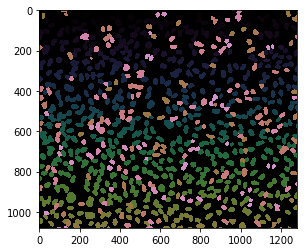

In [38]:
get_js_video(np.expand_dims(trial.y_tracked, axis=0))

In [ ]:
#get_js_video(test_data['y'])
get_js_video(train_dict['y'], batch=batch)
#get_js_video(train_dict['y'], batch=1)

## Generating a CSV of the Results

In [ ]:
from deepcell.model_zoo import siamese_model

train_dict, val_dict = get_data('/data/npz_data/cells/3T3/NIH/movie/nuclear_movie_3T3_and_HeLa.npz',
                                mode='siamese_daughters')

# Now we need to re-instantiate the model and load weights
directory = '/data/models/cells/3T3/NIH'
in_shape = (32, 32, 1)
features = {"appearance", "neighborhood", "distance", "regionprop"}
siamese_weights_file = '2018-11-15_nuclear_movie_3T3_and_HeLa_[a,d,n,r]_og=40_epochs=5_seed=777_multicell_0.h5'
siamese_weights_file = os.path.join(directory, siamese_weights_file)
tracking_model = siamese_model(input_shape=in_shape, occupancy_grid_size=40, features=features)
tracking_model.load_weights(siamese_weights_file)

In [ ]:
import importlib
import deepcell.tracking
importlib.reload(deepcell.tracking)

batch = 7
trial = deepcell.tracking.cell_tracker(train_dict['X'][batch], train_dict['y'][batch],
                     tracking_model,
                     max_distance=200,
                     track_length=5, division=0.5, birth=0.9, death=0.9,
                     neighborhood_scale_size=40,
                     features=features)
trial._track_cells()

In [ ]:
trial.dataframe()

In [23]:
trial.dump("dumps/3t3-hela_s12345b10.trk")

## Track Multiple Movies and Generate Track Files

In [18]:
import numpy as np
from deepcell.model_zoo import siamese_model

# Define source data
data = np.load('/data/data/cells/HEK293/generic/set0/deepcell_segmentations_v1/nuclear_movie_HEK293_set0_large.npz')
data.keys()
data_readable_X, data_readable_y = data['X'][()], data['y'][()]
print('X Shape:', data_readable_X.shape)
print('y Shape:', data_readable_y.shape)

X Shape: (1, 71, 1080, 1280, 1)
y Shape: (1, 71, 1080, 1280, 1)


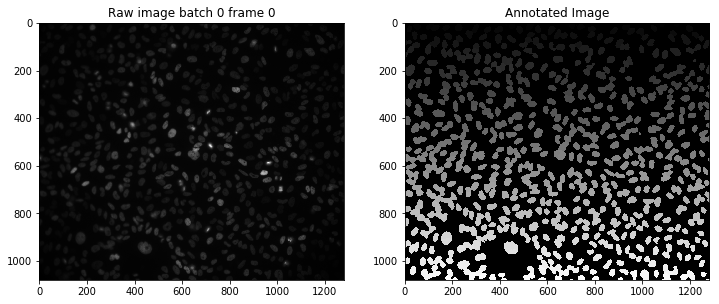

In [19]:
# Check data if needed
import matplotlib.pyplot as plt
from skimage.io import imshow

img_raw = data_readable_X[0,0,:,:,0]
img_ann = data_readable_y[0,0,:,:,0]

# Visualize the result 
fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(img_raw, interpolation='none', cmap='gray')
ax[1].imshow(img_ann, interpolation='none', cmap='gray')
ax[0].set_title('Raw image batch 0 frame 0')
ax[1].set_title('Annotated Image')
plt.show()

In [22]:
#base_path = "/data/data/cells/3T3/NIH/set0/deepcell_segmentations_v1/part_2/tracks/"
#base_name = "3T3_S0P2_Batch"

batch = 0
trial = deepcell.tracking.cell_tracker(data_readable_X[batch][0:30], data_readable_y[batch][0:30],
                     tracking_model,
                     max_distance=200,
                     track_length=5, division=0.5, birth=0.9, death=0.9,
                     neighborhood_scale_size=30,
                     features=features)
trial._track_cells()



/usr/local/lib/python3.5/dist-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/usr/local/lib/python3.5/dist-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabl

Tracking frame 1
cells in frame [1711 1712 1713 1714 1715 1716 1717 1718 1719 1720 1721 1722 1723 1724
 1725 1726 1727 1728 1729 1730 1731 1732 1733 1734 1735 1736 1737 1738
 1739 1740 1741 1742 1743 1744 1745 1746 1747 1748 1749 1750 1751 1752
 1753 1754 1755 1756 1757 1758 1759 1760 1761 1762 1763 1764 1765 1766
 1767 1768 1769 1770 1771 1772 1773 1774 1775 1776 1777 1778 1779 1780
 1781 1782 1783 1784 1785 1786 1787 1788 1789 1790 1791 1792 1793 1794
 1795 1796 1797 1798 1799 1800 1801 1802 1803 1804 1805 1806 1807 1808
 1809 1810 1811 1812 1813 1814 1815 1816 1817 1818 1819 1820 1821 1822
 1823 1824 1825 1826 1827 1828 1829 1830 1831 1832 1833 1834 1835 1836
 1837 1838 1839 1840 1841 1842 1843 1844 1845 1846 1847 1848 1849 1850
 1851 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861 1862 1863 1864
 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877 1878
 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892
 1893 1894 1895 1896 1897 1898 1899 1900 1901

New track
New track
New track
New track
New track
New track
Division detected
New track
New track
New track
New track
New track
New track
appearances removed from track  437
frames in the track  [0, 1, 2, 3]
length of daughter track  1
daughters  [753]
new track id  760
label  438
frame being removed  3
Tracking frame 4
cells in frame [3886 3887 3888 3889 3890 3891 3892 3893 3894 3895 3896 3897 3898 3899
 3900 3901 3902 3903 3904 3905 3906 3907 3908 3909 3910 3911 3912 3913
 3914 3915 3916 3917 3918 3919 3920 3921 3922 3923 3924 3925 3926 3927
 3928 3929 3930 3931 3932 3933 3934 3935 3936 3937 3938 3939 3940 3941
 3942 3943 3944 3945 3946 3947 3948 3949 3950 3951 3952 3953 3954 3955
 3956 3957 3958 3959 3960 3961 3962 3963 3964 3965 3966 3967 3968 3969
 3970 3971 3972 3973 3974 3975 3976 3977 3978 3979 3980 3981 3982 3983
 3984 3985 3986 3987 3988 3989 3990 3991 3992 3993 3994 3995 3996 3997
 3998 3999 4000 4001 4002 4003 4004 4005 4006 4007 4008 4009 4010 4011
 4012 4013 4014 4015 401

New track
Division detected
New track
New track
Division detected
New track
New track
New track
New track
New track
New track
Division detected
New track
New track
New track
New track
New track
New track
appearances removed from track  366
frames in the track  [0, 1, 2, 3, 4, 5]
length of daughter track  1
daughters  [784]
new track id  791
label  367
frame being removed  5
Tracking frame 6
cells in frame [5353 5354 5355 5356 5357 5358 5359 5360 5361 5362 5363 5364 5365 5366
 5367 5368 5369 5370 5371 5372 5373 5374 5375 5376 5377 5378 5379 5380
 5381 5382 5383 5384 5385 5386 5387 5388 5389 5390 5391 5392 5393 5394
 5395 5396 5397 5398 5399 5400 5401 5402 5403 5404 5405 5406 5407 5408
 5409 5410 5411 5412 5413 5414 5415 5416 5417 5418 5419 5420 5421 5422
 5423 5424 5425 5426 5427 5428 5429 5430 5431 5432 5433 5434 5435 5436
 5437 5438 5439 5440 5441 5442 5443 5444 5445 5446 5447 5448 5449 5450
 5451 5452 5453 5454 5455 5456 5457 5458 5459 5460 5461 5462 5463 5464
 5465 5466 5467 5468 54

Tracking frame 8
cells in frame [6823 6824 6825 6826 6827 6828 6829 6830 6831 6832 6833 6834 6835 6836
 6837 6838 6839 6840 6841 6842 6843 6844 6845 6846 6847 6848 6849 6850
 6851 6852 6853 6854 6855 6856 6857 6858 6859 6860 6861 6862 6863 6864
 6865 6866 6867 6868 6869 6870 6871 6872 6873 6874 6875 6876 6877 6878
 6879 6880 6881 6882 6883 6884 6885 6886 6887 6888 6889 6890 6891 6892
 6893 6894 6895 6896 6897 6898 6899 6900 6901 6902 6903 6904 6905 6906
 6907 6908 6909 6910 6911 6912 6913 6914 6915 6916 6917 6918 6919 6920
 6921 6922 6923 6924 6925 6926 6927 6928 6929 6930 6931 6932 6933 6934
 6935 6936 6937 6938 6939 6940 6941 6942 6943 6944 6945 6946 6947 6948
 6949 6950 6951 6952 6953 6954 6955 6956 6957 6958 6959 6960 6961 6962
 6963 6964 6965 6966 6967 6968 6969 6970 6971 6972 6973 6974 6975 6976
 6977 6978 6979 6980 6981 6982 6983 6984 6985 6986 6987 6988 6989 6990
 6991 6992 6993 6994 6995 6996 6997 6998 6999 7000 7001 7002 7003 7004
 7005 7006 7007 7008 7009 7010 7011 7012 7013

Tracking frame 10
cells in frame [8310 8311 8312 8313 8314 8315 8316 8317 8318 8319 8320 8321 8322 8323
 8324 8325 8326 8327 8328 8329 8330 8331 8332 8333 8334 8335 8336 8337
 8338 8339 8340 8341 8342 8343 8344 8345 8346 8347 8348 8349 8350 8351
 8352 8353 8354 8355 8356 8357 8358 8359 8360 8361 8362 8363 8364 8365
 8366 8367 8368 8369 8370 8371 8372 8373 8374 8375 8376 8377 8378 8379
 8380 8381 8382 8383 8384 8385 8386 8387 8388 8389 8390 8391 8392 8393
 8394 8395 8396 8397 8398 8399 8400 8401 8402 8403 8404 8405 8406 8407
 8408 8409 8410 8411 8412 8413 8414 8415 8416 8417 8418 8419 8420 8421
 8422 8423 8424 8425 8426 8427 8428 8429 8430 8431 8432 8433 8434 8435
 8436 8437 8438 8439 8440 8441 8442 8443 8444 8445 8446 8447 8448 8449
 8450 8451 8452 8453 8454 8455 8456 8457 8458 8459 8460 8461 8462 8463
 8464 8465 8466 8467 8468 8469 8470 8471 8472 8473 8474 8475 8476 8477
 8478 8479 8480 8481 8482 8483 8484 8485 8486 8487 8488 8489 8490 8491
 8492 8493 8494 8495 8496 8497 8498 8499 850

New track
New track
Division detected
New track
New track
New track
New track
Division detected
New track
New track
appearances removed from track  623
frames in the track  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
length of daughter track  1
daughters  [849]
new track id  852
label  624
frame being removed  11
appearances removed from track  791
frames in the track  [5, 6, 7, 8, 9, 10, 11]
length of daughter track  1
daughters  [845]
new track id  853
label  792
frame being removed  11
Tracking frame 12
cells in frame [ 9827  9828  9829  9830  9831  9832  9833  9834  9835  9836  9837  9838
  9839  9840  9841  9842  9843  9844  9845  9846  9847  9848  9849  9850
  9851  9852  9853  9854  9855  9856  9857  9858  9859  9860  9861  9862
  9863  9864  9865  9866  9867  9868  9869  9870  9871  9872  9873  9874
  9875  9876  9877  9878  9879  9880  9881  9882  9883  9884  9885  9886
  9887  9888  9889  9890  9891  9892  9893  9894  9895  9896  9897  9898
  9899  9900  9901  9902  9903  9904  99

New track
New track
New track
Division detected
New track
New track
Division detected
New track
New track
New track
Division detected
New track
New track
appearances removed from track  417
frames in the track  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
length of daughter track  1
daughters  [866]
new track id  872
label  418
frame being removed  13
appearances removed from track  451
frames in the track  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
length of daughter track  1
daughters  [869]
new track id  873
label  452
frame being removed  13
Tracking frame 14
cells in frame [11342 11343 11344 11345 11346 11347 11348 11349 11350 11351 11352 11353
 11354 11355 11356 11357 11358 11359 11360 11361 11362 11363 11364 11365
 11366 11367 11368 11369 11370 11371 11372 11373 11374 11375 11376 11377
 11378 11379 11380 11381 11382 11383 11384 11385 11386 11387 11388 11389
 11390 11391 11392 11393 11394 11395 11396 11397 11398 11399 11400 11401
 11402 11403 11404 11405 11406 11407 11408 1

New track
New track
New track
Division detected
New track
Division detected
New track
Division detected
New track
Division detected
New track
New track
New track
Division detected
New track
Division detected
New track
Division detected
New track
New track
New track
Tracking frame 16
cells in frame [12882 12883 12884 12885 12886 12887 12888 12889 12890 12891 12892 12893
 12894 12895 12896 12897 12898 12899 12900 12901 12902 12903 12904 12905
 12906 12907 12908 12909 12910 12911 12912 12913 12914 12915 12916 12917
 12918 12919 12920 12921 12922 12923 12924 12925 12926 12927 12928 12929
 12930 12931 12932 12933 12934 12935 12936 12937 12938 12939 12940 12941
 12942 12943 12944 12945 12946 12947 12948 12949 12950 12951 12952 12953
 12954 12955 12956 12957 12958 12959 12960 12961 12962 12963 12964 12965
 12966 12967 12968 12969 12970 12971 12972 12973 12974 12975 12976 12977
 12978 12979 12980 12981 12982 12983 12984 12985 12986 12987 12988 12989
 12990 12991 12992 12993 12994 12995 12996 1

New track
New track
New track
Tracking frame 18
cells in frame [14441 14442 14443 14444 14445 14446 14447 14448 14449 14450 14451 14452
 14453 14454 14455 14456 14457 14458 14459 14460 14461 14462 14463 14464
 14465 14466 14467 14468 14469 14470 14471 14472 14473 14474 14475 14476
 14477 14478 14479 14480 14481 14482 14483 14484 14485 14486 14487 14488
 14489 14490 14491 14492 14493 14494 14495 14496 14497 14498 14499 14500
 14501 14502 14503 14504 14505 14506 14507 14508 14509 14510 14511 14512
 14513 14514 14515 14516 14517 14518 14519 14520 14521 14522 14523 14524
 14525 14526 14527 14528 14529 14530 14531 14532 14533 14534 14535 14536
 14537 14538 14539 14540 14541 14542 14543 14544 14545 14546 14547 14548
 14549 14550 14551 14552 14553 14554 14555 14556 14557 14558 14559 14560
 14561 14562 14563 14564 14565 14566 14567 14568 14569 14570 14571 14572
 14573 14574 14575 14576 14577 14578 14579 14580 14581 14582 14583 14584
 14585 14586 14587 14588 14589 14590 14591 14592 14593 14594 

New track
Division detected
New track
Division detected
New track
New track
New track
New track
appearances removed from track  29
frames in the track  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
length of daughter track  1
daughters  [934]
new track id  940
label  30
frame being removed  19
Tracking frame 20
cells in frame [16009 16010 16011 16012 16013 16014 16015 16016 16017 16018 16019 16020
 16021 16022 16023 16024 16025 16026 16027 16028 16029 16030 16031 16032
 16033 16034 16035 16036 16037 16038 16039 16040 16041 16042 16043 16044
 16045 16046 16047 16048 16049 16050 16051 16052 16053 16054 16055 16056
 16057 16058 16059 16060 16061 16062 16063 16064 16065 16066 16067 16068
 16069 16070 16071 16072 16073 16074 16075 16076 16077 16078 16079 16080
 16081 16082 16083 16084 16085 16086 16087 16088 16089 16090 16091 16092
 16093 16094 16095 16096 16097 16098 16099 16100 16101 16102 16103 16104
 16105 16106 16107 16108 16109 16110 16111 16112 16113 16114 16

New track
New track
New track
Division detected
New track
New track
Tracking frame 22
cells in frame [17577 17578 17579 17580 17581 17582 17583 17584 17585 17586 17587 17588
 17589 17590 17591 17592 17593 17594 17595 17596 17597 17598 17599 17600
 17601 17602 17603 17604 17605 17606 17607 17608 17609 17610 17611 17612
 17613 17614 17615 17616 17617 17618 17619 17620 17621 17622 17623 17624
 17625 17626 17627 17628 17629 17630 17631 17632 17633 17634 17635 17636
 17637 17638 17639 17640 17641 17642 17643 17644 17645 17646 17647 17648
 17649 17650 17651 17652 17653 17654 17655 17656 17657 17658 17659 17660
 17661 17662 17663 17664 17665 17666 17667 17668 17669 17670 17671 17672
 17673 17674 17675 17676 17677 17678 17679 17680 17681 17682 17683 17684
 17685 17686 17687 17688 17689 17690 17691 17692 17693 17694 17695 17696
 17697 17698 17699 17700 17701 17702 17703 17704 17705 17706 17707 17708
 17709 17710 17711 17712 17713 17714 17715 17716 17717 17718 17719 17720
 17721 17722 17723 1772

New track
New track
New track
Division detected
New track
Division detected
Tracking frame 24
cells in frame [19149 19150 19151 19152 19153 19154 19155 19156 19157 19158 19159 19160
 19161 19162 19163 19164 19165 19166 19167 19168 19169 19170 19171 19172
 19173 19174 19175 19176 19177 19178 19179 19180 19181 19182 19183 19184
 19185 19186 19187 19188 19189 19190 19191 19192 19193 19194 19195 19196
 19197 19198 19199 19200 19201 19202 19203 19204 19205 19206 19207 19208
 19209 19210 19211 19212 19213 19214 19215 19216 19217 19218 19219 19220
 19221 19222 19223 19224 19225 19226 19227 19228 19229 19230 19231 19232
 19233 19234 19235 19236 19237 19238 19239 19240 19241 19242 19243 19244
 19245 19246 19247 19248 19249 19250 19251 19252 19253 19254 19255 19256
 19257 19258 19259 19260 19261 19262 19263 19264 19265 19266 19267 19268
 19269 19270 19271 19272 19273 19274 19275 19276 19277 19278 19279 19280
 19281 19282 19283 19284 19285 19286 19287 19288 19289 19290 19291 19292
 19293 19294 19

New track
New track
New track
New track
New track
Tracking frame 26
cells in frame [20725 20726 20727 20728 20729 20730 20731 20732 20733 20734 20735 20736
 20737 20738 20739 20740 20741 20742 20743 20744 20745 20746 20747 20748
 20749 20750 20751 20752 20753 20754 20755 20756 20757 20758 20759 20760
 20761 20762 20763 20764 20765 20766 20767 20768 20769 20770 20771 20772
 20773 20774 20775 20776 20777 20778 20779 20780 20781 20782 20783 20784
 20785 20786 20787 20788 20789 20790 20791 20792 20793 20794 20795 20796
 20797 20798 20799 20800 20801 20802 20803 20804 20805 20806 20807 20808
 20809 20810 20811 20812 20813 20814 20815 20816 20817 20818 20819 20820
 20821 20822 20823 20824 20825 20826 20827 20828 20829 20830 20831 20832
 20833 20834 20835 20836 20837 20838 20839 20840 20841 20842 20843 20844
 20845 20846 20847 20848 20849 20850 20851 20852 20853 20854 20855 20856
 20857 20858 20859 20860 20861 20862 20863 20864 20865 20866 20867 20868
 20869 20870 20871 20872 20873 20874 2087

New track
New track
Division detected
New track
Division detected
New track
Division detected
New track
New track
Division detected
New track
Tracking frame 28
cells in frame [22310 22311 22312 22313 22314 22315 22316 22317 22318 22319 22320 22321
 22322 22323 22324 22325 22326 22327 22328 22329 22330 22331 22332 22333
 22334 22335 22336 22337 22338 22339 22340 22341 22342 22343 22344 22345
 22346 22347 22348 22349 22350 22351 22352 22353 22354 22355 22356 22357
 22358 22359 22360 22361 22362 22363 22364 22365 22366 22367 22368 22369
 22370 22371 22372 22373 22374 22375 22376 22377 22378 22379 22380 22381
 22382 22383 22384 22385 22386 22387 22388 22389 22390 22391 22392 22393
 22394 22395 22396 22397 22398 22399 22400 22401 22402 22403 22404 22405
 22406 22407 22408 22409 22410 22411 22412 22413 22414 22415 22416 22417
 22418 22419 22420 22421 22422 22423 22424 22425 22426 22427 22428 22429
 22430 22431 22432 22433 22434 22435 22436 22437 22438 22439 22440 22441
 22442 22443 22444 224

New track
New track
Division detected
New track
New track
Division detected
New track
Division detected
New track
Division detected
New track
New track
Division detected
New track
Division detected
New track
New track
New track
Division detected
New track
Division detected
New track
appearances removed from track  120
frames in the track  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
length of daughter track  1
daughters  [1002]
new track id  1013
label  121
frame being removed  29
appearances removed from track  276
frames in the track  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
length of daughter track  1
daughters  [1006]
new track id  1014
label  277
frame being removed  29
appearances removed from track  510
frames in the track  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
length of da

In [39]:
channel = 0

for i in range(30):
    #name_raw = os.path.join('tracking_movies/3T3_S0P2_batch3_{:02}_.png'.format(i))
    name_tracked = os.path.join('tracking_movies/HEK293_set0_large_{:02}_.png'.format(i))
    #plt.imsave(name_raw, test_data['y'][0, i, :, :, channel], cmap='jet')
    plt.imsave(name_tracked, trial.y_tracked[i, :, :, channel], cmap='cubehelix', vmin=0, vmax=1500)


In [ ]:
import tensorflow as tf

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.optimizers import SGD, Adam
from tensorflow.python.keras.models import Sequential, Model

from deepcell import get_data
from deepcell import make_training_data
from deepcell import rate_scheduler
from deepcell.model_zoo import siamese_model
from deepcell.training import train_model_siamese_daughter

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output
import time

datagen_val = SiameseDataGenerator(
    rotation_range=180,  # randomly rotate images by 0 to rotation_range degrees
    shear_range=0,  # randomly shear images in the range (radians , -shear_range to shear_range)
    horizontal_flip=0,  # randomly flip images
    vertical_flip=0)  # randomly flip images

batch_size=128
min_track_length=5
# fit the model on the batches generated by datagen.flow()
test = datagen_val.flow(train_dict, batch_size=batch_size, min_track_length=min_track_length, shuffle=False)

cm = np.zeros((3,3))
N_div = 0.
N_tot = 0.

for batch_x, batch_y in test:
    clear_output(wait=True)
    
    y_pred = tracking_model.predict(batch_x)
    
    truth = np.argmax(batch_y, axis=-1)
    pred = np.argmax(y_pred, axis=-1)
    cm_temp = confusion_matrix(truth,pred)
    if cm_temp.shape[0] == 2:
        cm[0:2,0:2] += cm_temp
    else:
        cm += confusion_matrix(truth,pred)
        
    N_div += np.sum(truth == 2)
    N_tot += truth.shape[0]
    
    print(np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2), N_div/N_tot)

    
# y_true = test.classes
# y_pred = tracking_model.predict_generator(test)
# print(y_pred)
# Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
# y_pred = model.predict_classes(x_test)
# print(classification_report(y_true, np.argmax(y_pred, axis=-1)))

In [21]:
import os
import deepcell.tracking

# Now we need to re-instantiate the model and load weights
directory = '/data/models/cells/3T3/NIH'
in_shape = (32, 32, 1)
features = {"appearance", "neighborhood", "distance", "regionprop"}
siamese_weights_file = '2019-01-06_nuclear_movie_3T3_and_HeLa_complete_[a,d,n,r]_neighs=30_epochs=5_seed=88_trks_0.h5'
siamese_weights_file = os.path.join(directory, siamese_weights_file)
tracking_model = siamese_model(input_shape=in_shape, neighborhood_scale_size=30, features=features)
tracking_model.load_weights(siamese_weights_file)